# MTRN4110 Phase C
### Luke Jackson - z5162966

*Note, look for: "TUTORS HERE IS WHERE TO INSERT AN IMAGE ..." to find where to insert image if the warp transform does not work ... line 114 in [5]

In [1]:
# global variables
MAZE_FILE_NAME = "../Maze.png"
ROBOT_FILE_NAME = "../Robot.png"
IMAGE_LADYBUG_FILE_NAME = "../Ladybug_small.png"
MAP_FILE_NAME = "../MapBuilt.txt"
MAP_WIDTH = 1350 # ratio = 9:5
MAP_HEIGHT = 750

In [2]:
# imports
import cv2 as cv # OpenCV library
import numpy as np # Numpy library for scientific computing
import matplotlib.pyplot as plt # Matplotlib library for plotting
import math

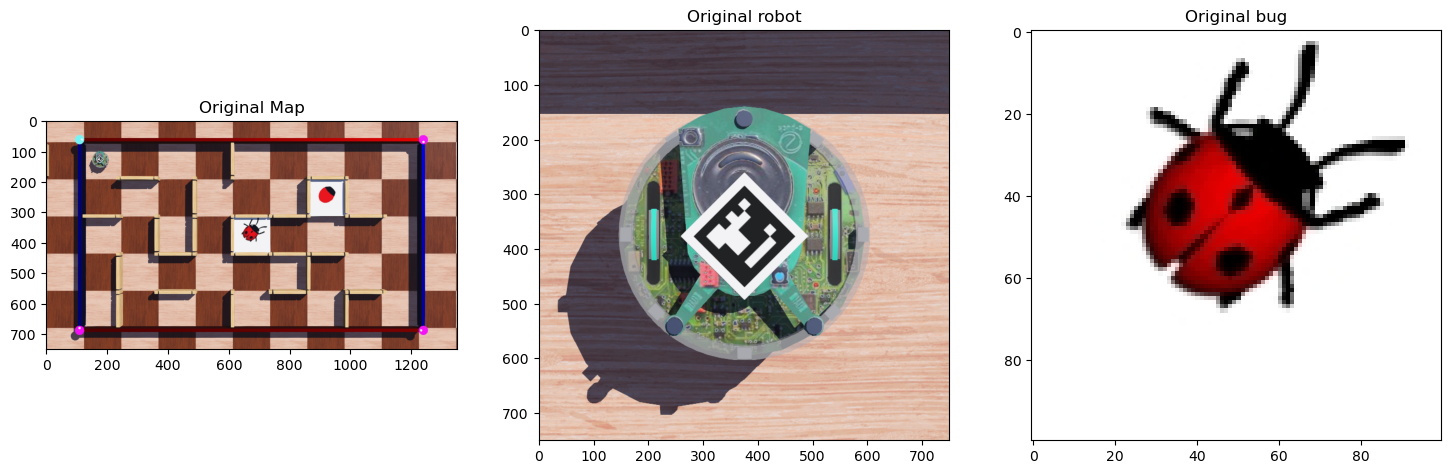

In [3]:
# load all images and do any cropping if required
og_map_img = cv.imread(MAZE_FILE_NAME)
og_map_img_rgb = cv.cvtColor(og_map_img, cv.COLOR_BGR2RGB)
og_robot_img = cv.imread(ROBOT_FILE_NAME)
og_robot_img_rgb = cv.cvtColor(og_robot_img, cv.COLOR_BGR2RGB)
og_bug_img = cv.imread(IMAGE_LADYBUG_FILE_NAME)
og_bug_img_rgb = cv.cvtColor(og_bug_img, cv.COLOR_BGR2RGB)

# crop robot image
#og_robot_img_rgb = og_robot_img_rgb[100:640,110:640]

fig, (ax1, ax2, ax3) = plt.subplots(figsize = (18, 10), ncols = 3)
ax1.imshow(og_map_img_rgb), ax1.set_title("Original Map")
ax2.imshow(og_robot_img_rgb), ax2.set_title("Original robot")
ax3.imshow(og_bug_img_rgb), ax3.set_title("Original bug")
plt.show()

### Load map, transform to top-down - I do two passes which improves output for very askew image inputs

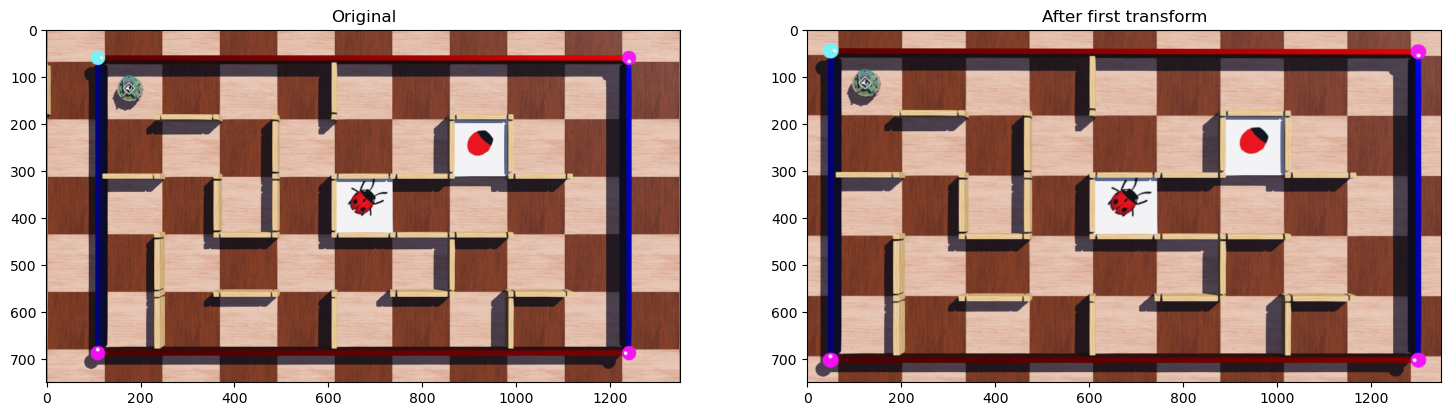

In [4]:
# returns the quadrant given coordinates of the image -> (1 = topLeft, 2 = topRight, 3 = bottomLeft, 4 = bottomRight)
def coordToQuad(x, y):
    if x > MAP_WIDTH/2:
        if y > MAP_HEIGHT/2:
            #BottomRight
            return 3
        else:
            #TopRight
            return 1
    else:
        if y > MAP_HEIGHT/2:
            #BottomLeft
            return 2
        else:
            #TopLeft
            return 0

# drawing circles around bright circles
# convert map down to only magenta POI
og_map_img_hsv = cv.cvtColor(og_map_img, cv.COLOR_BGR2HSV)
hsv_min = (100,100,230) 
hsv_max = (170,255,255)
mag_corners = cv.inRange(og_map_img_hsv, hsv_min, hsv_max) 
# masking off corners and converting image to Black and White
(h,s,v) = cv.split(og_map_img_hsv)
mag_corners = cv.bitwise_and(h, mag_corners)
mag_corners = cv.medianBlur(mag_corners,7)
(thresh, mag_corners) = cv.threshold(mag_corners, 10, 255, cv.THRESH_BINARY) 
# convert map down to only cyan POI
hsv_min = (86,123,230) 
hsv_max = (95,153,255)
cyan_corners = cv.inRange(og_map_img_hsv, hsv_min, hsv_max) 
# masking off corners and converting image to Black and White
(h,s,v) = cv.split(og_map_img_hsv)
cyan_corners = cv.bitwise_and(h, cyan_corners)
cyan_corners = cv.medianBlur(cyan_corners,7)
(thresh, cyan_corners) = cv.threshold(cyan_corners, 10, 255, cv.THRESH_BINARY) 

# using Hough circle detection to locate corner circles
mag_corner_circles = cv.HoughCircles(mag_corners, cv.HOUGH_GRADIENT, 1, minDist=120, param1=20, param2=4, minRadius=5, maxRadius=30)
cyan_corner_circles = cv.HoughCircles(cyan_corners, cv.HOUGH_GRADIENT, 1, minDist=120, param1=20, param2=4, minRadius=5, maxRadius=30)
mag_corner_circles = np.round(mag_corner_circles[0, :]).astype("int")
cyan_corner_circles = np.round(cyan_corner_circles[0, :]).astype("int")

# sort from smallest to largest in x ->
mag_corner_circles = sorted(mag_corner_circles, key=lambda x: x[0])

# assign position of circle to position in array (0 = topLeft, 1 = topRight, 2 = bottomLeft, 3 = bottomRight)
quadrant = coordToQuad(cyan_corner_circles[0][0], cyan_corner_circles[0][1])
imageFlipped = False
offsetAmnt = 45
skipNewTransform = False
if cyan_corner_circles[0][0] < offsetAmnt or mag_corner_circles[0][0] < offsetAmnt or mag_corner_circles[1][0] > MAP_WIDTH - offsetAmnt or mag_corner_circles[2][0] > MAP_WIDTH - offsetAmnt:
    skipNewTransform = True
    print("No offset occuring")
    offsetAmnt = 0
    
if quadrant != 0: # it is in the bottom right then
    imageFlipped = True
    quadrant_0 = coordToQuad(mag_corner_circles[0][0], mag_corner_circles[0][1])
    if quadrant_0 == 2:
        #print("case1")
        og_points = np.array([[cyan_corner_circles[0][0] + offsetAmnt, cyan_corner_circles[0][1] + offsetAmnt],
                 [mag_corner_circles[2][0] + offsetAmnt,mag_corner_circles[2][1] - offsetAmnt],
                 [mag_corner_circles[0][0] - offsetAmnt,mag_corner_circles[0][1] + offsetAmnt],
                 [mag_corner_circles[1][0] - offsetAmnt,mag_corner_circles[1][1] - offsetAmnt]])
    else: # quadrant_0 == 1
        #print("case2")
        og_points = np.array([[cyan_corner_circles[0][0] + offsetAmnt, cyan_corner_circles[0][1] + offsetAmnt],
                 [mag_corner_circles[2][0] + offsetAmnt,mag_corner_circles[2][1] - offsetAmnt],
                 [mag_corner_circles[1][0] - offsetAmnt,mag_corner_circles[1][1] + offsetAmnt],
                 [mag_corner_circles[0][0] - offsetAmnt,mag_corner_circles[0][1] - offsetAmnt]])
else:
    if mag_corner_circles[0][0] > cyan_corner_circles[0][0] and mag_corner_circles[1][0] < mag_corner_circles[2][0] and mag_corner_circles[1][1] > mag_corner_circles[2][1]: # slanted inwards
        #print("case 2.5")
        og_points = np.array([[cyan_corner_circles[0][0], cyan_corner_circles[0][1]],
                     [mag_corner_circles[0][0],mag_corner_circles[0][1]],
                     [mag_corner_circles[2][0],mag_corner_circles[2][1]],
                     [mag_corner_circles[1][0],mag_corner_circles[1][1]]])
    elif mag_corner_circles[0][0] < cyan_corner_circles[0][0] and mag_corner_circles[1][0] < mag_corner_circles[2][0] and mag_corner_circles[1][1] < mag_corner_circles[2][1]: # slanted outwards
        #print("case 2.6")
        og_points = np.array([[cyan_corner_circles[0][0], cyan_corner_circles[0][1]],
                     [mag_corner_circles[0][0],mag_corner_circles[0][1]],
                     [mag_corner_circles[1][0],mag_corner_circles[1][1]],
                     [mag_corner_circles[2][0],mag_corner_circles[2][1]]])
    elif mag_corner_circles[0][0] < cyan_corner_circles[0][0]: # angled downwards
        #print("case3")
        og_points = np.array([[cyan_corner_circles[0][0] - offsetAmnt, cyan_corner_circles[0][1] - offsetAmnt],
                     [mag_corner_circles[0][0] - offsetAmnt, mag_corner_circles[0][1] + offsetAmnt],
                     [mag_corner_circles[2][0] + offsetAmnt,mag_corner_circles[2][1] - offsetAmnt],
                     [mag_corner_circles[1][0] + offsetAmnt,mag_corner_circles[1][1] + offsetAmnt]])
    elif mag_corner_circles[0][0] > cyan_corner_circles[0][0]: #angled upwards
        #print("case4")
        og_points = np.array([[cyan_corner_circles[0][0] - offsetAmnt, cyan_corner_circles[0][1] - offsetAmnt],
                     [mag_corner_circles[0][0] - offsetAmnt,mag_corner_circles[0][1] + offsetAmnt],
                     [mag_corner_circles[1][0] + offsetAmnt,mag_corner_circles[1][1] - offsetAmnt],
                     [mag_corner_circles[2][0] + offsetAmnt,mag_corner_circles[2][1] + offsetAmnt]])
    else: #when equalled
        #print("case5")
        og_points = np.array([[cyan_corner_circles[0][0] - offsetAmnt, cyan_corner_circles[0][1] - offsetAmnt],
                     [mag_corner_circles[0][0] - offsetAmnt,mag_corner_circles[0][1] + offsetAmnt],
                     [mag_corner_circles[2][0] + offsetAmnt,mag_corner_circles[2][1] - offsetAmnt],
                     [mag_corner_circles[1][0] + offsetAmnt,mag_corner_circles[1][1] + offsetAmnt]])
        
#print(cyan_corner_circles)     
#print(mag_corner_circles)     
# perspecgive transform
og_points_comb = np.float32(og_points)
new_points = np.float32([[0,0],[0,MAP_HEIGHT],[MAP_WIDTH,0],[MAP_WIDTH,MAP_HEIGHT]]) # four points on the second image
H = cv.getPerspectiveTransform(og_points_comb,new_points) # homography matrix
map_transformed = cv.warpPerspective(og_map_img_rgb, H, (MAP_WIDTH, MAP_HEIGHT))

# display the maps - original and repositioned
fig, (ax1, ax2) = plt.subplots(figsize = (18, 10), ncols = 2)
ax1.imshow(og_map_img_rgb), ax1.set_title("Original")
ax2.imshow(map_transformed), ax2.set_title("After first transform") #(In RGB mode)
plt.show()

### Run same above code as a final pass but this time draw circles on the corners

Warp Transformed to fit screen


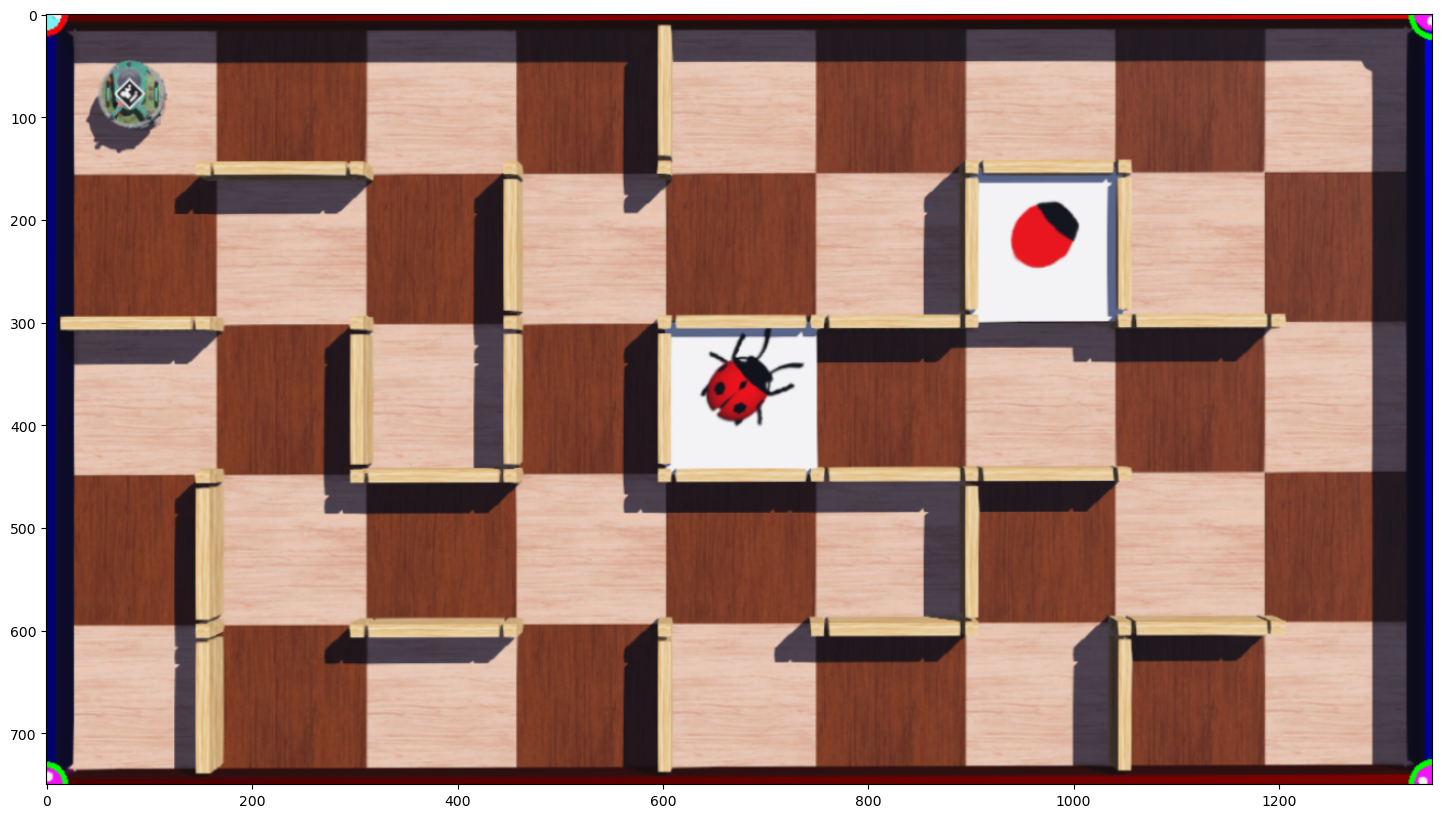

In [5]:
# returns the quadrant given coordinates of the image -> (1 = topLeft, 2 = topRight, 3 = bottomLeft, 4 = bottomRight)
def coordToQuad(x, y):
    if x > MAP_WIDTH/2:
        if y > MAP_HEIGHT/2:
            #BottomRight
            return 3
        else:
            #TopRight
            return 1
    else:
        if y > MAP_HEIGHT/2:
            #BottomLeft
            return 2
        else:
            #TopLeft
            return 0
if skipNewTransform == False:
    map_transformed_copy = map_transformed.copy()

    # drawing circles around bright circles
    # convert map down to only magenta POI
    og_map_img_hsv = cv.cvtColor(map_transformed_copy, cv.COLOR_RGB2HSV)
    hsv_min = (100,100,230) 
    hsv_max = (170,255,255)
    mag_corners = cv.inRange(og_map_img_hsv, hsv_min, hsv_max) 
    # masking off corners and converting image to Black and White
    (h,s,v) = cv.split(og_map_img_hsv)
    mag_corners = cv.bitwise_and(h, mag_corners)
    mag_corners = cv.medianBlur(mag_corners,7)
    (thresh, mag_corners) = cv.threshold(mag_corners, 10, 255, cv.THRESH_BINARY) 
    # convert map down to only cyan POI
    hsv_min = (86,123,230) 
    hsv_max = (95,153,255)
    cyan_corners = cv.inRange(og_map_img_hsv, hsv_min, hsv_max) 
    # masking off corners and converting image to Black and White
    (h,s,v) = cv.split(og_map_img_hsv)
    cyan_corners = cv.bitwise_and(h, cyan_corners)
    cyan_corners = cv.medianBlur(cyan_corners,7)
    (thresh, cyan_corners) = cv.threshold(cyan_corners, 10, 255, cv.THRESH_BINARY) 

    # using Hough circle detection to locate corner circles
    mag_corner_circles = cv.HoughCircles(mag_corners, cv.HOUGH_GRADIENT, 1, minDist=100, param1=20, param2=5, minRadius=5, maxRadius=30)
    cyan_corner_circles = cv.HoughCircles(cyan_corners, cv.HOUGH_GRADIENT, 1, minDist=100, param1=20, param2=5, minRadius=5, maxRadius=30)
    # Draw circles
    if mag_corner_circles is not None and cyan_corner_circles is not None:
        mag_corner_circles = np.round(mag_corner_circles[0, :]).astype("int")
        cyan_corner_circles = np.round(cyan_corner_circles[0, :]).astype("int")
        for (x,y,r) in mag_corner_circles:
            cv.circle(map_transformed_copy, (x,y), r + 2, (0,255,0), 3)
        for (x,y,r) in cyan_corner_circles:
            cv.circle(map_transformed_copy, (x,y), r + 2, (255,0,0), 3)

    # sort from smallest to largest in x ->
    mag_corner_circles = sorted(mag_corner_circles, key=lambda x: x[0])

    # assign position of circle to position in array (0 = topLeft, 1 = topRight, 2 = bottomLeft, 3 = bottomRight)
    quadrant = coordToQuad(cyan_corner_circles[0][0], cyan_corner_circles[0][1])
    if quadrant != 0: # it is in the bottom right then
        imageFlipped = True
        quadrant_0 = coordToQuad(mag_corner_circles[0][0], mag_corner_circles[0][1])
        if quadrant_0 == 2:
            #print("case1")
            og_points = np.array([[cyan_corner_circles[0][0], cyan_corner_circles[0][1]],
                     [mag_corner_circles[2][0],mag_corner_circles[2][1]],
                     [mag_corner_circles[0][0],mag_corner_circles[0][1]],
                     [mag_corner_circles[1][0],mag_corner_circles[1][1]]])
        else: # quadrant_0 == 1
            #print("case2")
            og_points = np.array([[cyan_corner_circles[0][0], cyan_corner_circles[0][1]],
                     [mag_corner_circles[2][0],mag_corner_circles[2][1]],
                     [mag_corner_circles[1][0],mag_corner_circles[1][1]],
                     [mag_corner_circles[0][0],mag_corner_circles[0][1]]])
    else:
        if mag_corner_circles[0][0] > cyan_corner_circles[0][0] and mag_corner_circles[1][0] < mag_corner_circles[2][0] and mag_corner_circles[1][1] > mag_corner_circles[2][1]: # slanted inwards
            #print("case 2.5")
            og_points = np.array([[cyan_corner_circles[0][0], cyan_corner_circles[0][1]],
                         [mag_corner_circles[0][0],mag_corner_circles[0][1]],
                         [mag_corner_circles[2][0],mag_corner_circles[2][1]],
                         [mag_corner_circles[1][0],mag_corner_circles[1][1]]])
        elif mag_corner_circles[0][0] < cyan_corner_circles[0][0]: # angled downwards
            #print("case3")
            og_points = np.array([[cyan_corner_circles[0][0], cyan_corner_circles[0][1]],
                         [mag_corner_circles[0][0],mag_corner_circles[0][1]],
                         [mag_corner_circles[2][0],mag_corner_circles[2][1]],
                         [mag_corner_circles[1][0],mag_corner_circles[1][1]]])
        elif mag_corner_circles[0][0] > cyan_corner_circles[0][0]: #angled upwards
            #print("case4")
            og_points = np.array([[cyan_corner_circles[0][0], cyan_corner_circles[0][1]],
                         [mag_corner_circles[0][0],mag_corner_circles[0][1]],
                         [mag_corner_circles[1][0],mag_corner_circles[1][1]],
                         [mag_corner_circles[2][0],mag_corner_circles[2][1]]])
        else: #when equalled
            #print("case5")
            og_points = np.array([[cyan_corner_circles[0][0], cyan_corner_circles[0][1]],
                         [mag_corner_circles[0][0],mag_corner_circles[0][1]],
                         [mag_corner_circles[1][0],mag_corner_circles[1][1]],
                         [mag_corner_circles[2][0],mag_corner_circles[2][1]]])

    #print(cyan_corner_circles)     
    #print(mag_corner_circles)     
    # perspecgive transform
    og_points_comb = np.float32(og_points)
    new_points = np.float32([[0,0],[0,MAP_HEIGHT],[MAP_WIDTH,0],[MAP_WIDTH,MAP_HEIGHT]]) # four points on the second image
    H = cv.getPerspectiveTransform(og_points_comb,new_points) # homography matrix
    map_transformed = cv.warpPerspective(map_transformed_copy, H, (MAP_WIDTH, MAP_HEIGHT))

# display the maps - original and repositioned
print("Warp Transformed to fit screen")
plt.figure(figsize = (18, 10))
plt.imshow(map_transformed)
plt.show()

# TUTORS HERE IS WHERE TO INSERT AN IMAGE IF THE MAP TRANSFORM DOES NOT WORK!!
# map_transformed = ....



### find and mark walls

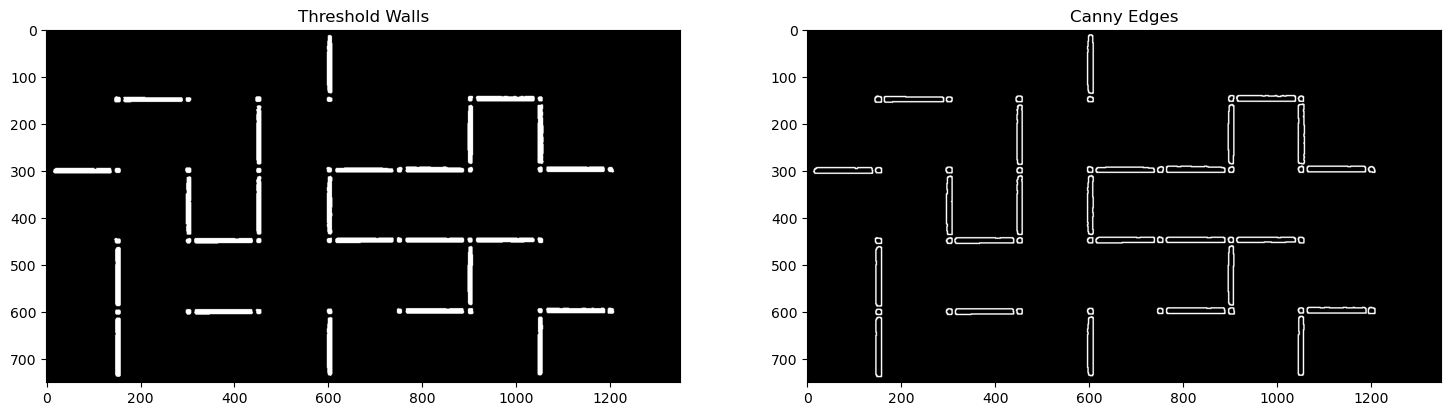

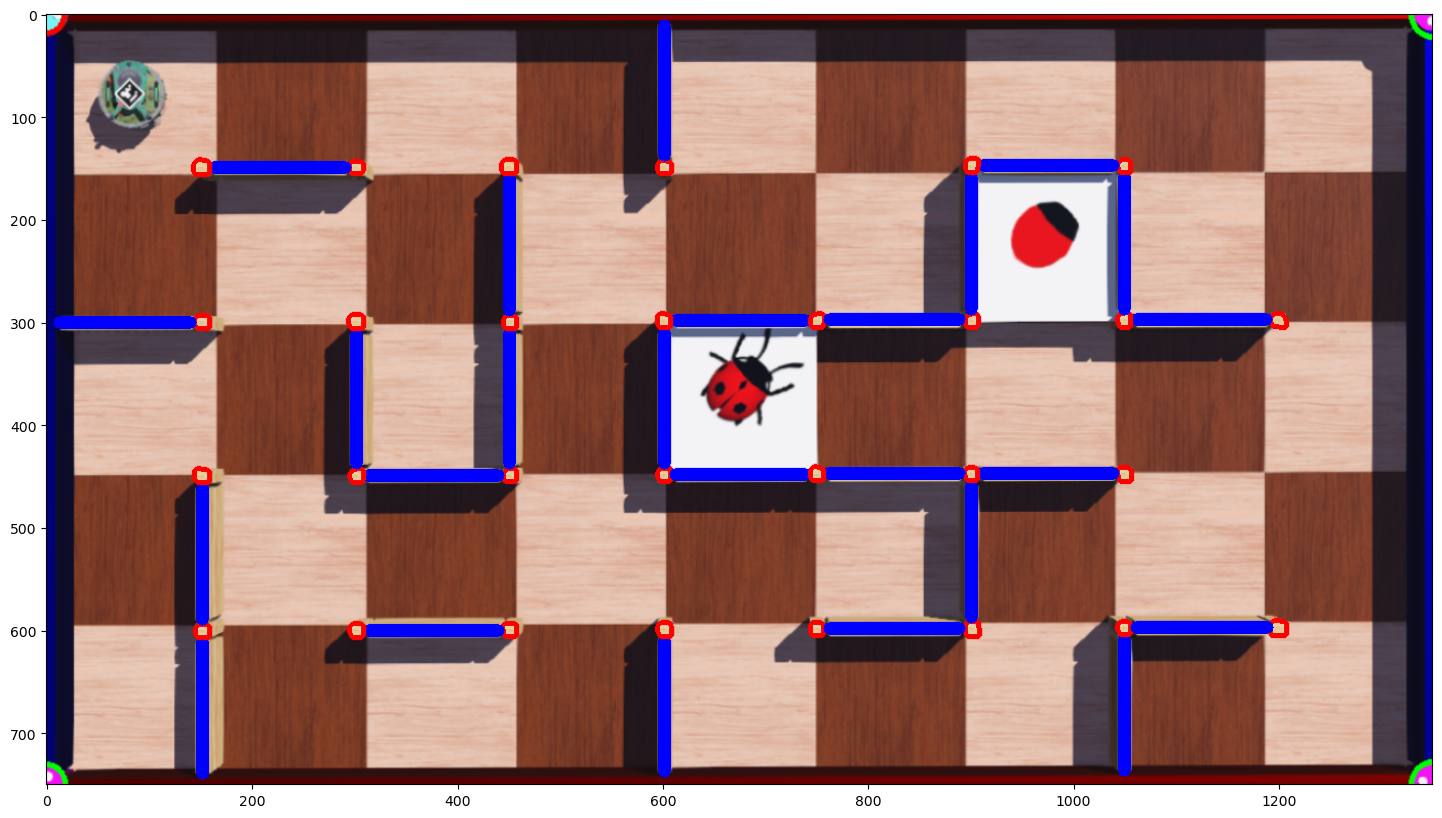

In [6]:
# detecting walls
map_transformed_rgb = map_transformed
map_transformed_bgr = cv.cvtColor(map_transformed, cv.COLOR_RGB2BGR)
map_transformed_hsv = cv.cvtColor(map_transformed, cv.COLOR_RGB2HSV) 
map_transformed_gray = cv.cvtColor(map_transformed, cv.COLOR_RGB2GRAY)

# reduce to walls only
#hsv_min = np.array([13,37,213])
#hsv_max = np.array([39,167,244])

hsv_min = np.array([15,63,226])
hsv_max = np.array([21,132,2555])

walls = cv.inRange(map_transformed_hsv, hsv_min, hsv_max)
walls = cv.medianBlur(walls,5)



# find and draw on walls
edges = cv.Canny(walls, threshold1 = 100, threshold2 = 200, apertureSize = 3)

kernel = np.ones((3,3), np.uint8)
edges = cv.dilate(edges, kernel, iterations = 1)

fig, (ax1, ax2) = plt.subplots(figsize = (18, 10), ncols = 2)
ax1.imshow(walls, cmap = 'gray'), ax1.set_title("Threshold Walls")
ax2.imshow(edges, cmap = 'gray'), ax2.set_title("Canny Edges")
plt.show()

#contour detection
img2, contours, hierarchy = cv.findContours(edges, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
map_walls_marked = map_transformed_bgr.copy()

for i, cnt in enumerate(contours):
    if cv.contourArea(cnt) > 280: #this means it is a wall section
        # get all 4 corners to then find centre line using midpoints
        # extremes = left, right, top, bottom
        # extremes = lower side, upper side, lower height, upper height
        extremes = [cnt[0,0,0], cnt[0,0,0], cnt[0,0,1], cnt[0,0,1]]
        for vals in cnt:  
            for x,y in vals:
                if x > extremes[1]:
                    extremes[1]= x
                elif x < extremes[0]:
                    extremes[0] = x
                if y > extremes[3]:
                    extremes[3] = y
                elif y < extremes[2]:
                    extremes[2] = y
        midPoints = [int((extremes[0] + extremes[1]) / 2), int((extremes[2] + extremes[3]) / 2)]
        # check if horizontal or vertical rectangle
        if (extremes[1] - extremes[0] > extremes[3] - extremes[2]):
            #horizontal
            cv.line(map_walls_marked, (extremes[0], midPoints[1] ), (extremes[1], midPoints[1]), (255,0,0), 12)
        else:
            #vertical
            cv.line(map_walls_marked, (midPoints[0], extremes[2]), (midPoints[0], extremes[3]), (255,0,0), 12)           
    else: #this is for the sections between the walls
        cv.drawContours(map_walls_marked, contours, i, (0, 0, 255), 3)
        #print("Small contour:")
        #print(cnt)

map_walls_marked = cv.cvtColor(map_walls_marked, cv.COLOR_BGR2RGB)

plt.figure(figsize = (18, 10))
plt.imshow(map_walls_marked)
plt.show()    

### locating robot in map

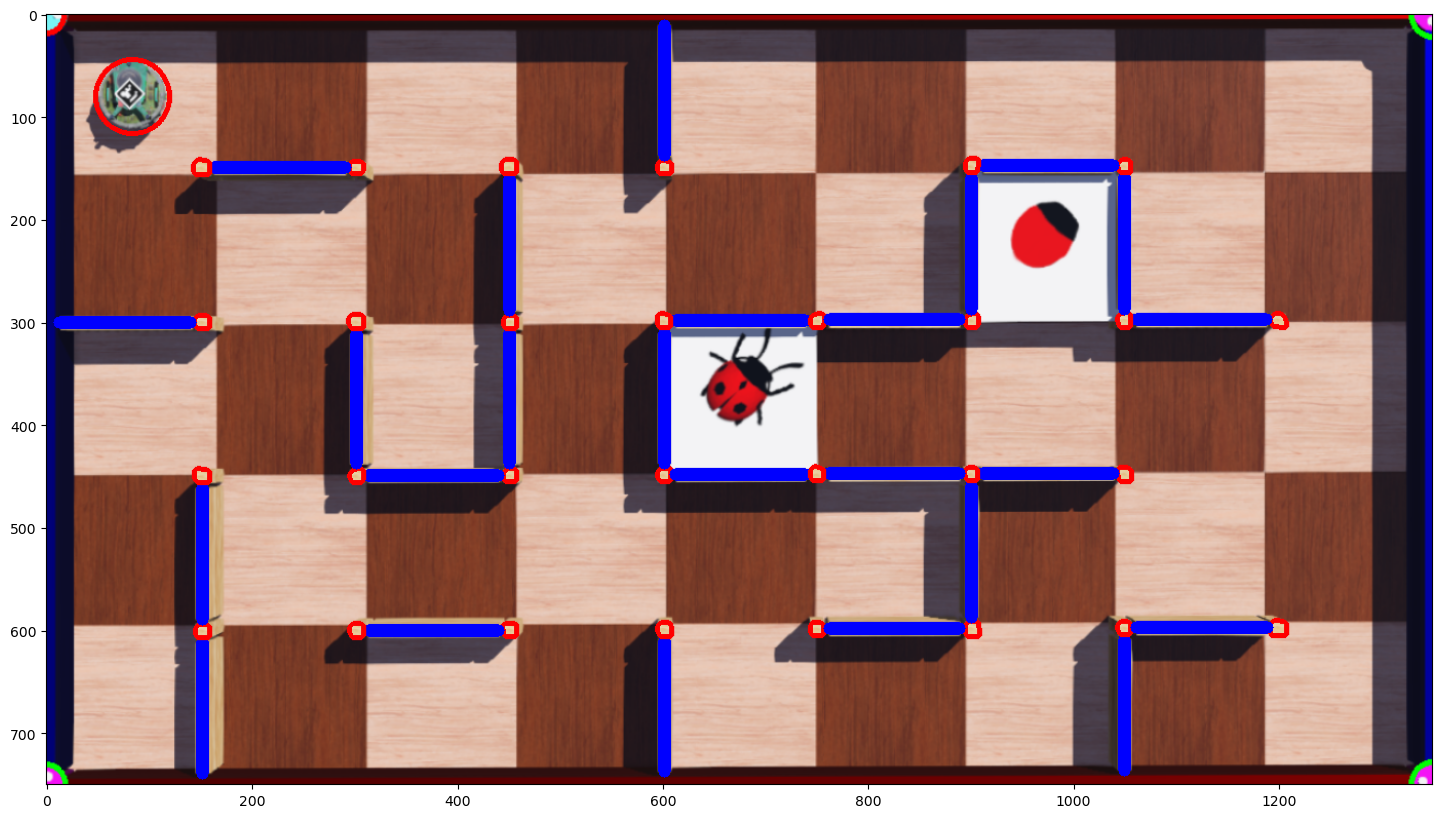

In [7]:
#using thresholding to locate the robot
hsv_min = np.array([26,3,87])
hsv_max = np.array([109,108,171])

robot_hsv = map_transformed_hsv
robot_hsv = cv.inRange(robot_hsv, hsv_min, hsv_max)
(h,s,v) = cv.split(map_transformed_hsv)
robot_hsv = cv.bitwise_and(h, robot_hsv)
robot_hsv = cv.medianBlur(robot_hsv,3)

robot_isolated = cv.HoughCircles(robot_hsv, cv.HOUGH_GRADIENT, 1, minDist=300, param1=15, param2=7, minRadius=10, maxRadius=50)
robot_centre = None
if robot_isolated is not None:
    robot_isolated = np.round(robot_isolated[0, :]).astype("int")
    for (x,y,r) in robot_isolated:
        robot_centre = (x-12,y+11)
        cv.circle(map_walls_marked, (x,y), r + 7, (255,0,0), 3)

plt.figure(figsize = (18,10))
plt.imshow(map_walls_marked)
plt.show() 


### Locating heading of robot using ArUco markers
code utilised and modified from provided tutorial code

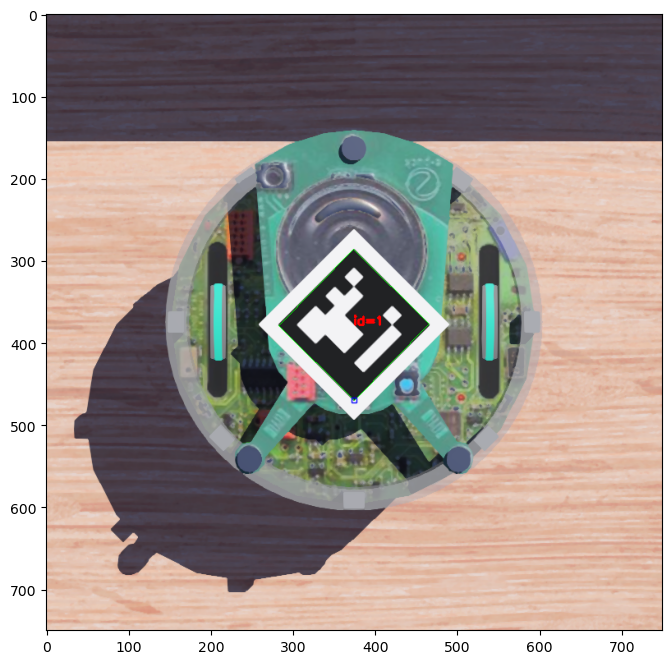

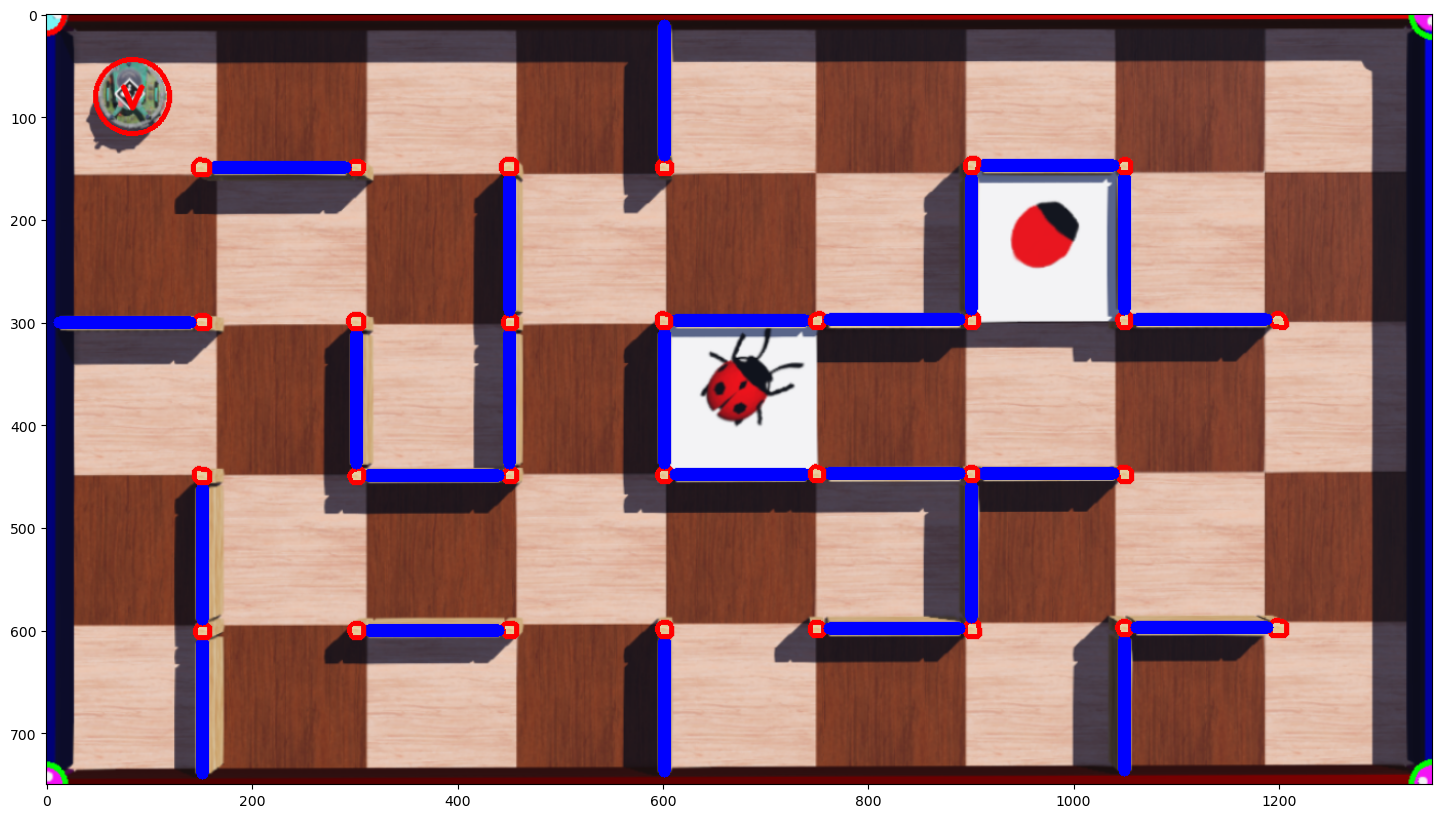

In [8]:
# Use provided high resolution robot image to find heading (og_robot_img_rgb)

# Load the predefined ArUco marker dictionary
dictionary = cv.aruco.Dictionary_get(cv.aruco.DICT_6X6_250)

# Generate the marker
markerImage = np.zeros((200, 200), dtype=np.uint8)
markerImage = cv.aruco.drawMarker(dictionary, 33, 200, markerImage, 1)

# Detect ArUco markers
# image is loaded with imread command 

img_bgr = cv.cvtColor(og_robot_img_rgb,cv.COLOR_RGB2BGR)
img_bgr = cv.medianBlur(img_bgr,3)
img_rgb_origin = cv.cvtColor(img_bgr,cv.COLOR_BGR2RGB)
img_rgb = cv.cvtColor(img_bgr,cv.COLOR_BGR2RGB)

# Load the predefined dictionary
dictionary = cv.aruco.Dictionary_get(cv.aruco.DICT_6X6_250)

# Initialize the detector parameters using default values
parameters = cv.aruco.DetectorParameters_create()

# Detect the markers in the image
corners, ids, rejectedCandidates = cv.aruco.detectMarkers(img_rgb, dictionary, parameters=parameters)
img_rgb = cv.aruco.drawDetectedMarkers(img_rgb, corners, ids)

plt.figure(figsize = (8,8))
plt.imshow(img_rgb)
plt.show() 

# find orientation of the ArUco
# up, right, down, left
if (corners[0][0][0][0] < corners[0][0][1][0] and corners[0][0][0][0] > corners[0][0][3][0]) or (corners[0][0][0][0] > corners[0][0][1][0] and corners[0][0][0][0] < corners[0][0][3][0]):
    if corners[0][0][0][1] < corners[0][0][3][1]:
        # up
        direction = 0
    else:
        # down
        direction = 2
else:
    if corners[0][0][0][0] < corners[0][0][2][0]:
        # right
        direction = 1   
    else:
        # left
        direction = 3


        
if imageFlipped == True:
    if direction > 1:
        direction = direction - 2
    else:
        direction = direction + 2

#print(direction)
#print(imageFlipped)
#print(corners)      
map_direction_marked = map_walls_marked.copy()
font = cv.FONT_HERSHEY_SIMPLEX
color = (255, 0, 0)
thickness = 3
if direction == 0 and robot_centre is not None:
    map_direction_marked = cv.putText(map_direction_marked, '^', robot_centre, font, 1.5, color, thickness, cv.LINE_AA)
elif direction == 1:
    map_direction_marked = cv.putText(map_direction_marked, '<', robot_centre, font, 1.5, color, thickness, cv.LINE_AA)
elif direction == 2:
    map_direction_marked = cv.putText(map_direction_marked, 'v', robot_centre, font, 1.5, color, thickness, cv.LINE_AA)
elif direction == 3:
    map_direction_marked = cv.putText(map_direction_marked, '>', robot_centre, font, 1.5, color, thickness, cv.LINE_AA)
if robot_centre is None:
    robot_centre = (75,75)
#plot the image
plt.figure(figsize = (18,10))
plt.imshow(map_direction_marked)
plt.show() 

### finding the correct beetle (end point)
template matching guided by: https://docs.opencv.org/4.5.2/d4/dc6/tutorial_py_template_matching.html

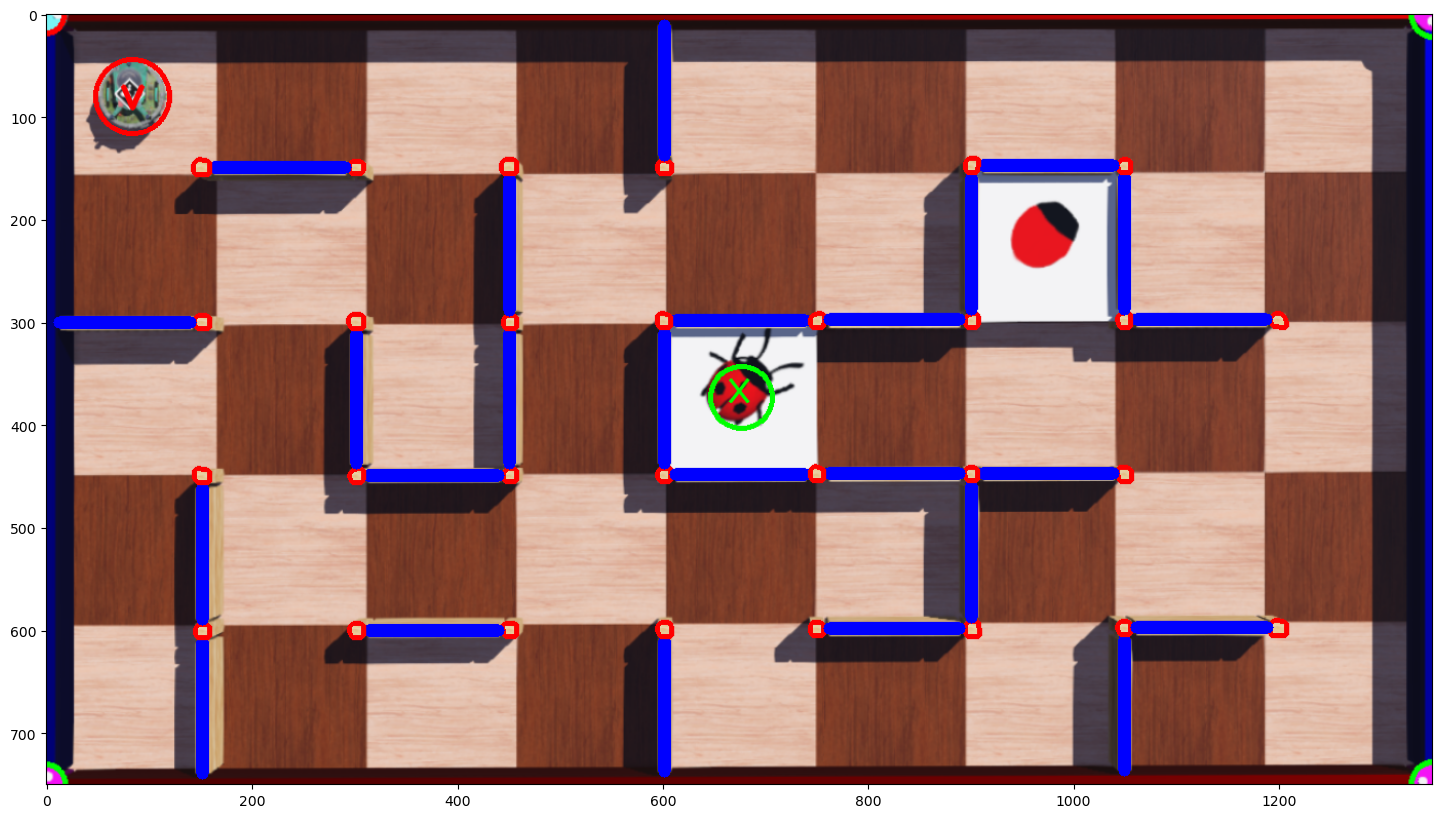

In [9]:
# Use scale-invariant template matching (constantly scale image down finding the best match)
# og_bug_img_rgb <- template
# map_direction_marked <- source

currentSize = 200
bug_img_resize = cv.resize(og_bug_img_rgb, (currentSize,currentSize), interpolation = cv.INTER_CUBIC)

bailOut = 0
resizeAmnt = 1
highest_result = 0
best_loc = [0,0]
best_size = 0
while currentSize > 100 and bailOut < 500:
    result = cv.matchTemplate(map_direction_marked, bug_img_resize, cv.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(result)
    if max_val > highest_result:
        highest_result = max_val
        best_loc = max_loc
        best_size = currentSize

    # resize the bug image
    currentSize -= resizeAmnt
    bug_img_resize = cv.resize(bug_img_resize, (currentSize,currentSize), interpolation = cv.INTER_CUBIC)
    bailOut += 1

x = best_loc[0] + int(best_size/2)
y = best_loc[1] + int(best_size/2)
bugLocation = (x-15,y+4)
# draw circle around image and X at the centre
fully_marked_map = cv.circle(map_direction_marked, (x,y), 30, (0,255,0), 3)
fully_marked_map = cv.putText(fully_marked_map, 'x', bugLocation, cv.FONT_HERSHEY_SIMPLEX, 1.5, (0,255,0), 2, cv.LINE_AA)

plt.figure(figsize = (18,10))
plt.imshow(fully_marked_map)
plt.show()


### Constructing a text map

In [10]:
# MAP_FILE_NAME = "../MapBuilt.txt"
# fully_marked_map <- RGB
# start at (0,0), each cell = ~(150 x 150), move along and if a blue cell is seen then this means a wall is there
# MAP_WIDTH = 1350, MAP_HEIGHT = 750

def isBlue(x, y):
    if fully_marked_map[x][y][0] == 0 and fully_marked_map[x][y][1] == 0 and fully_marked_map[x][y][2] == 255:
        return True
    return False


outputFile = open(MAP_FILE_NAME,"w")

cellWidth = 150
cellCentre = int(cellWidth/2)

topWall = " --- --- --- --- --- --- --- --- --- "
#print(robot_centre)
robot_pos = (round((robot_centre[0] - 75) / 150), round((robot_centre[1] - 75) / 150))
print("robot position =",robot_pos)

#print(bugLocation)
bug_pos = (round((bugLocation[0] - 75) / 150), round((bugLocation[1] - 75) / 150))
print("bug position =",bug_pos)
print("Printing map:")

# setup first line
print(topWall, end='')
outputFile.write(topWall)

for row in range(0,5):
    print()
    outputFile.write("\n")
    print('|', end='')
    outputFile.write("|")
    
    for col in range(0,9):
        if row == robot_pos[1] and col == robot_pos[0]:
            # robot location, print the heading
            if direction == 0:
                print(" ^ ", end='')
                outputFile.write(" ^ ")
            elif direction == 1:
                print(" < ", end='')
                outputFile.write(" < ")
            elif direction == 2:
                print(" v ", end='')
                outputFile.write(" v ")
            elif direction == 3:
                print(" > ", end='')
                outputFile.write(" > ")
        elif row == bug_pos[1] and col == bug_pos[0]:
            # end location
            print(" x ",end='')
            outputFile.write(" x ")
        else:
            print("   ", end='')
            outputFile.write("   ")
        wallFound = False
        
        # looping through for vertical walls
        if col != 8:
            for rowPixel in range(cellCentre + col * 149, cellCentre + (col + 1) * 149):
                if isBlue(cellCentre + row * 149, rowPixel):
                    wallFound = True
            if wallFound == True:
                print('|', end='')
                outputFile.write("|")
            else:
                print(' ', end='')
                outputFile.write(" ")
    print('|', end='')
    outputFile.write("|")
    
    # now run through checking for horizontal walls
    if row == 4: break
    print()
    outputFile.write("\n")
    print(' ',end='')
    outputFile.write(" ")
    for colPixel in range (0,9):
        wallFound = False
        for rowPixel in range (cellCentre + row * 150, cellCentre + (row + 1) * 150):
            if isBlue(rowPixel, cellCentre + colPixel * 150):
                wallFound = True

        if wallFound == True:
            print('---', end='')
            outputFile.write("---")
        else:
            print('   ', end='')
            outputFile.write("   ")
        print(' ', end='')
        outputFile.write(" ")
    
    

# setup first line
print()
outputFile.write("\n")
print(topWall, end='')
outputFile.write(topWall)
        
outputFile.close()

robot position = (0, 0)
bug position = (4, 2)
Printing map:
 --- --- --- --- --- --- --- --- --- 
| v             |                   |
     ---                 ---         
|           |           |   |       |
 ---             --- ---     ---     
|       |   |   | x                 |
         ---     --- --- ---         
|   |                   |           |
         ---         ---     ---     
|   |           |           |       |
 --- --- --- --- --- --- --- --- --- 